### Step 1: Load and Inspect Data

This cell reads in the raw CIDDS log file and displays its structure so we can verify that columns are correctly parsed before cleaning.

In [3]:
import pandas as pd  # for data manipulation

# Load the raw dataset into a DataFrame
df = pd.read_csv("/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection//data/raw/cidds-001-external-week1.csv")

# Show first five rows to confirm parsing
df.head()

# Display info: row count, column dtypes, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172838 entries, 0 to 172837
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date first seen    172838 non-null  object 
 1   Duration           172838 non-null  float64
 2   Proto              172838 non-null  object 
 3   Src IP Addr        172838 non-null  object 
 4   Src Pt             172838 non-null  int64  
 5   Dst IP Addr        172838 non-null  object 
 6   Dst Pt             172838 non-null  float64
 7   Packets            172838 non-null  int64  
 8   Bytes              172838 non-null  object 
 9   Flows              172838 non-null  int64  
 10  Flags              172838 non-null  object 
 11  Tos                172838 non-null  int64  
 12  class              172838 non-null  object 
 13  attackType         172838 non-null  object 
 14  attackID           172838 non-null  object 
 15  attackDescription  172838 non-null  object 
dtypes:

### Step 2: Data Cleaning & Preprocessing

This cell parses the timestamp column, converts key fields to numeric types, transforms the `Bytes` column into raw byte counts, encodes the `class` column into a binary `label`, and removes unnecessary metadata columns.

In [4]:
import numpy as np

# Work on a copy of the raw DataFrame
df_clean = df.copy()

# Parse 'Date first seen' into datetime objects
df_clean['Date first seen'] = pd.to_datetime(df_clean['Date first seen'], errors='coerce')

# Convert duration, ports, packet counts, flows, and TOS to numeric
numeric_cols = ['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Flows', 'Tos']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Convert 'Bytes' strings (e.g. "2.1 M") into numeric byte counts
def parse_bytes(val):
    if isinstance(val, str):
        v = val.strip().upper().replace(' ', '')
        if v.endswith('K'):
            return float(v[:-1]) * 1_000
        if v.endswith('M'):
            return float(v[:-1]) * 1_000_000
        if v.endswith('G'):
            return float(v[:-1]) * 1_000_000_000
        try:
            return float(v)
        except ValueError:
            return np.nan
    return val

df_clean['Bytes'] = df_clean['Bytes'].apply(parse_bytes)

# Encode 'class' into binary label: 0 = normal, 1 = attack
df_clean['label'] = (df_clean['class'].str.lower() == 'attack').astype(int)

# Drop attackID and attackDescription as they are not needed for modeling
df_clean.drop(['attackID', 'attackDescription'], axis=1, inplace=True)

# Preview the cleaned DataFrame
df_clean.head()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172838 entries, 0 to 172837
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date first seen  172838 non-null  datetime64[ns]
 1   Duration         172838 non-null  float64       
 2   Proto            172838 non-null  object        
 3   Src IP Addr      172838 non-null  object        
 4   Src Pt           172838 non-null  int64         
 5   Dst IP Addr      172838 non-null  object        
 6   Dst Pt           172838 non-null  float64       
 7   Packets          172838 non-null  int64         
 8   Bytes            172838 non-null  float64       
 9   Flows            172838 non-null  int64         
 10  Flags            172838 non-null  object        
 11  Tos              172838 non-null  int64         
 12  class            172838 non-null  object        
 13  attackType       172838 non-null  object        
 14  label            172

### Step 3: Protocol Distribution

This cell computes the frequency and percentage of each protocol in the cleaned CIDDS dataset to understand which network protocols dominate the traffic.

In [5]:
# Calculate protocol counts and percentages
proto_counts = df_clean['Proto'].value_counts()
proto_perc = df_clean['Proto'].value_counts(normalize=True) * 100

# Combine into a DataFrame for display
protocol_df = pd.DataFrame({
    'Count': proto_counts,
    'Percentage': proto_perc.round(2)
})

# Show the protocol distribution
protocol_df

,Count,Percentage
Proto,,
TCP,168800,97.66
UDP,2233,1.29
ICMP,1768,1.02
GRE,37,0.02


### Step 4: Identify Top Source and Destination IPs

This cell finds the top 10 source IP addresses and top 10 destination IP addresses by record count to reveal the most active endpoints in the network logs.

In [6]:
import pandas as pd  # for tabular display

# Top 10 source IPs by record count
top_sources = df_clean["Src IP Addr"].value_counts().head(10)
src_df = pd.DataFrame({
    "Source IP": top_sources.index,
    "Count": top_sources.values
})

# Top 10 destination IPs by record count
top_destinations = df_clean["Dst IP Addr"].value_counts().head(10)
dst_df = pd.DataFrame({
    "Destination IP": top_destinations.index,
    "Count": top_destinations.values
})

# Display the results
src_df, dst_df

(       Source IP  Count
 0     EXT_SERVER  86255
 1  OPENSTACK_NET  24803
 2       10004_36   7404
 3       10006_27   4557
 4       15588_32   3170
 5      10767_152   2871
 6       14105_47   2757
 7       17173_42   1514
 8       12875_68   1498
 9      10012_231   1351,
   Destination IP  Count
 0     EXT_SERVER  86583
 1  OPENSTACK_NET  24803
 2       10004_36   7404
 3       10006_27   4557
 4       15588_32   3170
 5      10767_152   2871
 6       14105_47   2757
 7       17173_42   1514
 8       12875_68   1498
 9      10012_231   1351)

### Step 5: Save the Cleaned Data

This cell writes the cleaned DataFrame `df_clean` into your project’s `data/processed/` folder so you can reliably load it in later notebooks.

In [10]:
import os

# Ensure the processed directory exists
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

# Save cleaned DataFrame as CSV
output_path = os.path.join(processed_dir, "cidds_week1_cleaned.csv")
df_clean.to_csv(output_path, index=False)

# Confirm where it was saved
print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: ../data/processed/cidds_week1_cleaned.csv


### Step 6: Load Cleaned Data for Visualization

This cell reads the cleaned dataset from its absolute path so we can plot the top IP bar charts without a FileNotFoundError.

In [12]:
import pandas as pd  # for data loading
import matplotlib.pyplot as plt  # for plotting

# Load the cleaned data using the absolute path on your machine
cleaned_path = "/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/data/processed/cidds_week1_cleaned.csv"
df = pd.read_csv(cleaned_path)

# Confirm it loaded correctly
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (172838, 15)


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,label
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2100000.0,1,.AP...,0,normal,---,0
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2500000.0,1,.AP...,0,normal,---,0
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9100000.0,1,.AP...,0,normal,---,0
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10300000.0,1,.AP...,0,normal,---,0
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27200000.0,1,.AP.S.,0,normal,---,0


### Step 7: Visualize Top IP Activity

This cell generates bar charts for the top 10 source IP addresses and the top 10 destination IP addresses by record count, highlighting the hosts with the most traffic.

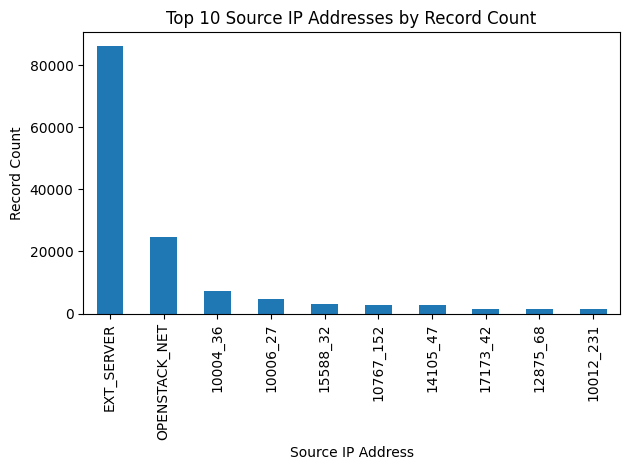

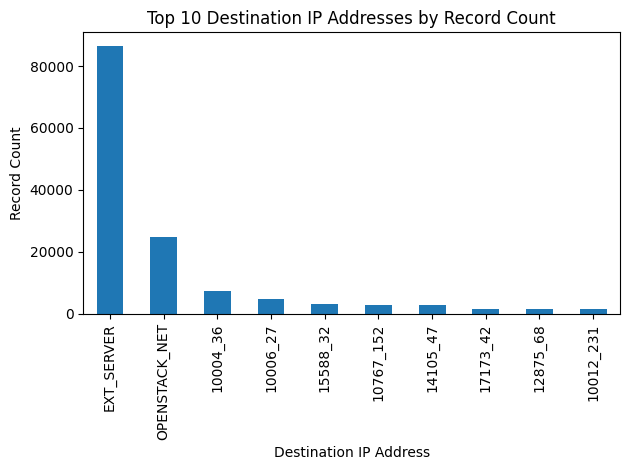

In [13]:
import pandas as pd           # for data loading
import matplotlib.pyplot as plt  # for plotting

# Load the cleaned dataset from the absolute path
cleaned_path = "/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/data/processed/cidds_week1_cleaned.csv"
df = pd.read_csv(cleaned_path)

# Compute the top 10 source IPs and top 10 destination IPs
top_sources = df["Src IP Addr"].value_counts().head(10)
top_destinations = df["Dst IP Addr"].value_counts().head(10)

# Plot bar chart for top source IPs
plt.figure()
top_sources.plot(kind="bar")
plt.title("Top 10 Source IP Addresses by Record Count")
plt.xlabel("Source IP Address")
plt.ylabel("Record Count")
plt.tight_layout()
plt.show()

# Plot bar chart for top destination IPs
plt.figure()
top_destinations.plot(kind="bar")
plt.title("Top 10 Destination IP Addresses by Record Count")
plt.xlabel("Destination IP Address")
plt.ylabel("Record Count")
plt.tight_layout()
plt.show()

### Step 8: Numeric Feature Distributions

This cell generates histograms for the key numeric features (`Duration`, `Packets`, `Bytes`) to visualize their distributions and surface any outliers.

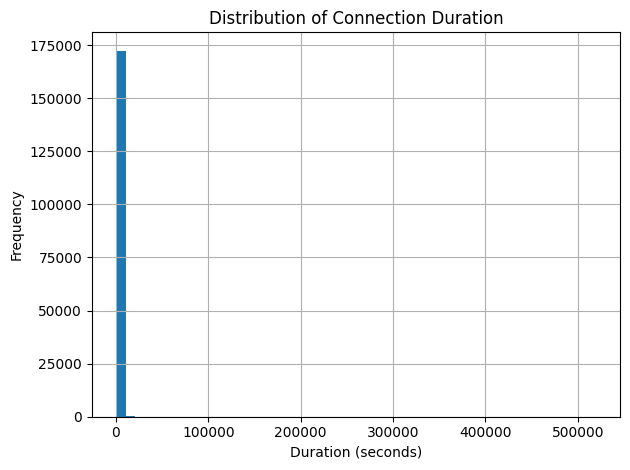

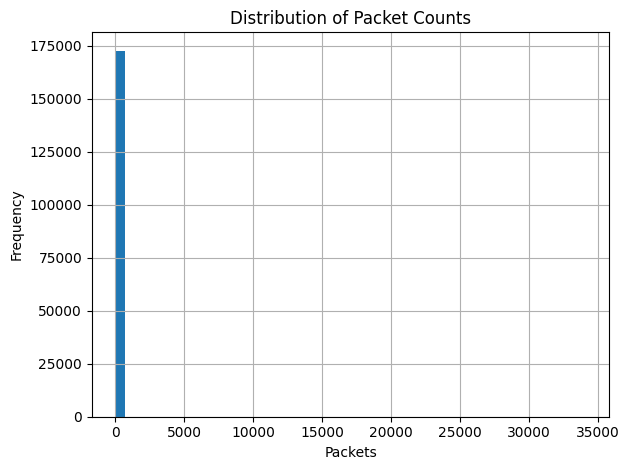

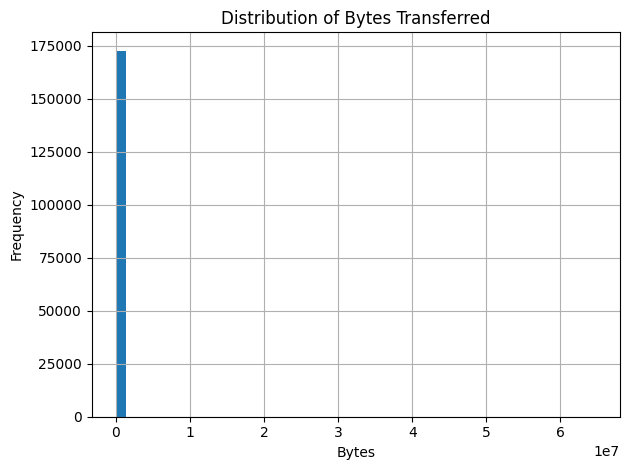

In [14]:
import pandas as pd           # for data loading
import matplotlib.pyplot as plt  # for plotting

# Load the cleaned dataset
cleaned_path = "/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/data/processed/cidds_week1_cleaned.csv"
df = pd.read_csv(cleaned_path)

# Histogram: Connection Duration
plt.figure()
df['Duration'].hist(bins=50)
plt.title('Distribution of Connection Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram: Packet Counts
plt.figure()
df['Packets'].hist(bins=50)
plt.title('Distribution of Packet Counts')
plt.xlabel('Packets')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram: Bytes Transferred
plt.figure()
df['Bytes'].hist(bins=50)
plt.title('Distribution of Bytes Transferred')
plt.xlabel('Bytes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Step 8b: Duration Distribution (Log Scale)

This cell plots the `Duration` distribution on a logarithmic x-axis so you can see the spread of values when most connections are very short but a few last much longer.

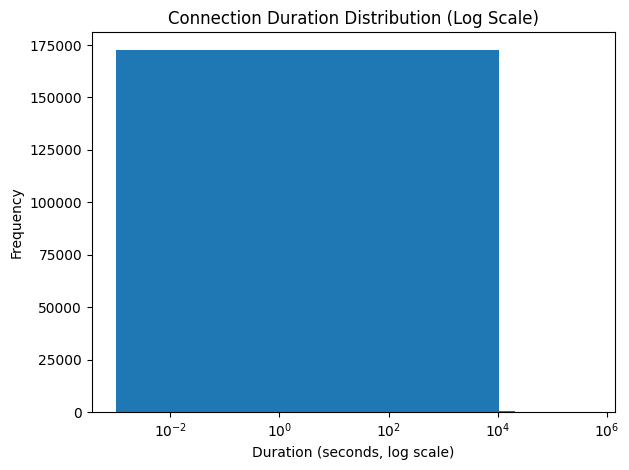

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned data (adjust the path to your environment if needed)
df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")

# Add a small constant to avoid log(0)
durations = df["Duration"] + 1e-3

# Plot histogram on a log x-scale
plt.figure()
plt.hist(durations, bins=50)
plt.xscale("log")
plt.title("Connection Duration Distribution (Log Scale)")
plt.xlabel("Duration (seconds, log scale)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Step 9: Packet Count Distribution (Log Scale)

This cell plots the distribution of `Packets` on a logarithmic x-axis to spread out the heavy clustering at low counts and reveal the long tail of high-packet connections.

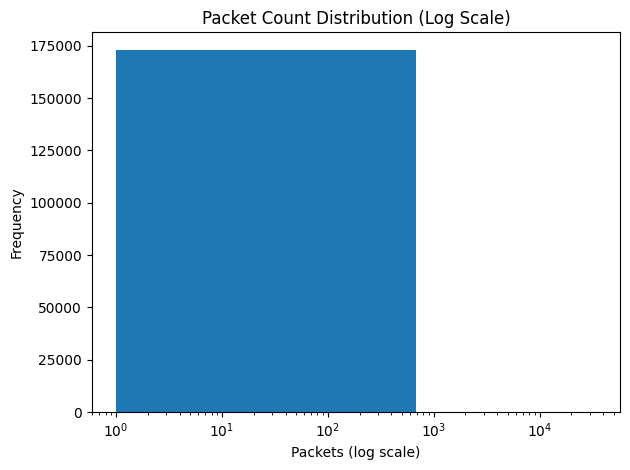

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/data/processed/cidds_week1_cleaned.csv")

# Add a small constant to avoid log(0)
packets = df["Packets"] + 1e-3

# Plot histogram on a log x-scale
plt.figure()
plt.hist(packets, bins=50)
plt.xscale("log")
plt.title("Packet Count Distribution (Log Scale)")
plt.xlabel("Packets (log scale)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Step 10: Bytes Transferred Distribution (Log Scale)

This cell plots the distribution of `Bytes` on a logarithmic x-axis to visualize the spread of transfer sizes, from very small to very large.

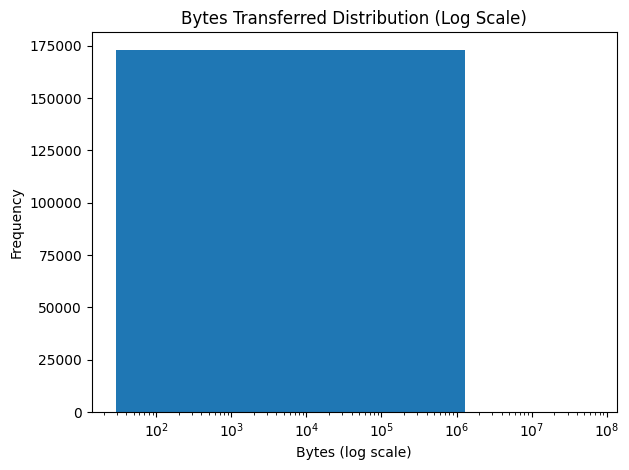

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("/Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/data/processed/cidds_week1_cleaned.csv")

# Add a small constant to avoid log(0)
bytes_transferred = df["Bytes"] + 1

# Plot histogram on a log x-scale
plt.figure()
plt.hist(bytes_transferred, bins=50)
plt.xscale("log")
plt.title("Bytes Transferred Distribution (Log Scale)")
plt.xlabel("Bytes (log scale)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()